In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from thor_magni_tools.utils.load import load_csv_metadata_magni, preprocessing_header_magni
from thor_magni_tools.preprocessing.filtering import Filterer3DOF

In [77]:
VISUALS_PATH = "../datasets/thor_magni_pub_ready/maps/THOR-MAGNI_Maps"
SCENARIO = "Scenario_1"
PATH = f"../datasets/thor_magni_pub_ready/{SCENARIO}"
DAY = "1805"

In [78]:
vis_path = os.path.join(VISUALS_PATH, f"{DAY}Map.png")
img = Image.open(vis_path)
targ_img = np.array(img)
map_layout  = np.flipud(targ_img[:,:,:3])

In [79]:
data = {
    run: load_csv_metadata_magni(os.path.join(PATH, run))[0]
    for run in os.listdir(PATH)
    if DAY in run
}

In [80]:
data = dict(sorted(data.items()))
data.keys()

dict_keys(['THOR-Magni_180522_SC1A_R1.csv', 'THOR-Magni_180522_SC1A_R2.csv', 'THOR-Magni_180522_SC1B_R1.csv', 'THOR-Magni_180522_SC1B_R2.csv'])

In [81]:
class PixWorldConverter:
    """Pixel to world converter"""

    def __init__(self, info: dict) -> None:
        self.resolution = info["resolution_pm"]  # 1pix -> m
        self.offset = np.array(info["offset"])

    def convert2pixels(self, world_locations: np.array) -> np.array:
        if world_locations.ndim == 2:
            return (world_locations / self.resolution) - self.offset

        new_world_locations = [
            self.convert2pixels(world_location) for world_location in world_locations
        ]
        return np.stack(new_world_locations)

    def convert2world(self, pix_locations: np.array) -> np.array:
        return (pix_locations + self.offset) * self.resolution

In [82]:
info =  {"resolution_pm" : 0.01, "offset": [-860, -1050]} # may experiments  # september exp {"resolution_pm": 0.01, "offset": [-650, -1040]} 
pix2world_converter = PixWorldConverter(info)

# Helper pix -> m

In [83]:
new_data = {
    run: data[run][
        data[run].columns[
            (data[run].columns.str.contains("DARKO_Robot"))
            & (
                (data[run].columns.str.endswith(" X"))
                | (data[run].columns.str.endswith(" Y"))
            )
        ]
    ] / 1000
    for run in data.keys()
}

In [84]:
new_data.keys()

dict_keys(['THOR-Magni_180522_SC1A_R1.csv', 'THOR-Magni_180522_SC1A_R2.csv', 'THOR-Magni_180522_SC1B_R1.csv', 'THOR-Magni_180522_SC1B_R2.csv'])

In [85]:
all_locations = {run: None for run in new_data.keys()}
for run, input_df in new_data.items():
    input_df = new_data[run]
    x_coordinate = input_df[input_df.columns[input_df.columns.str.endswith("X")]]
    x_cols = x_coordinate.columns

    markers = (
        x_coordinate[x_cols[x_cols.str.startswith(f"DARKO_Robot -")]]
        .columns.str.split(regex=r" (/d) ")
        .str[2]
    )
    locations = {}
    for marker_id in markers:
        locations[marker_id] = [
            input_df[f"DARKO_Robot - {marker_id} X"].mean(),
            input_df[f"DARKO_Robot - {marker_id} Y"].mean(),
        ]
    locations_px = np.array(list(locations.values()))
    locations_px = np.round(pix2world_converter.convert2pixels(locations_px), 2)
    all_locations[run] = {
        marker_id: location_px.tolist()
        for marker_id, location_px in zip(locations.keys(), locations_px)
    }

In [86]:
all_locations

{'THOR-Magni_180522_SC1A_R1.csv': {'1': [466.35, 930.9],
  '2': [473.08, 931.82],
  '3': [385.09, 951.63],
  '4': [431.22, 973.92],
  '5': [381.96, 924.79],
  '6': [412.16, 887.2],
  '7': [364.29, 929.56]},
 'THOR-Magni_180522_SC1A_R2.csv': {'1': [466.26, 930.9],
  '2': [473.07, 931.82],
  '3': [385.1, 951.62],
  '4': [431.24, 973.93],
  '5': [382.53, 924.69],
  '6': [412.31, 887.16],
  '7': [364.37, 929.38]},
 'THOR-Magni_180522_SC1B_R1.csv': {'1': [466.32, 930.9],
  '2': [473.09, 931.82],
  '3': [385.06, 951.64],
  '4': [431.22, 973.96],
  '5': [381.8, 924.84],
  '6': [412.08, 887.25],
  '7': [364.25, 929.69]},
 'THOR-Magni_180522_SC1B_R2.csv': {'1': [466.4, 930.89],
  '2': [473.09, 931.83],
  '3': [385.1, 951.64],
  '4': [431.22, 973.97],
  '5': [381.83, 924.83],
  '6': [412.09, 887.23],
  '7': [364.27, 929.65]}}

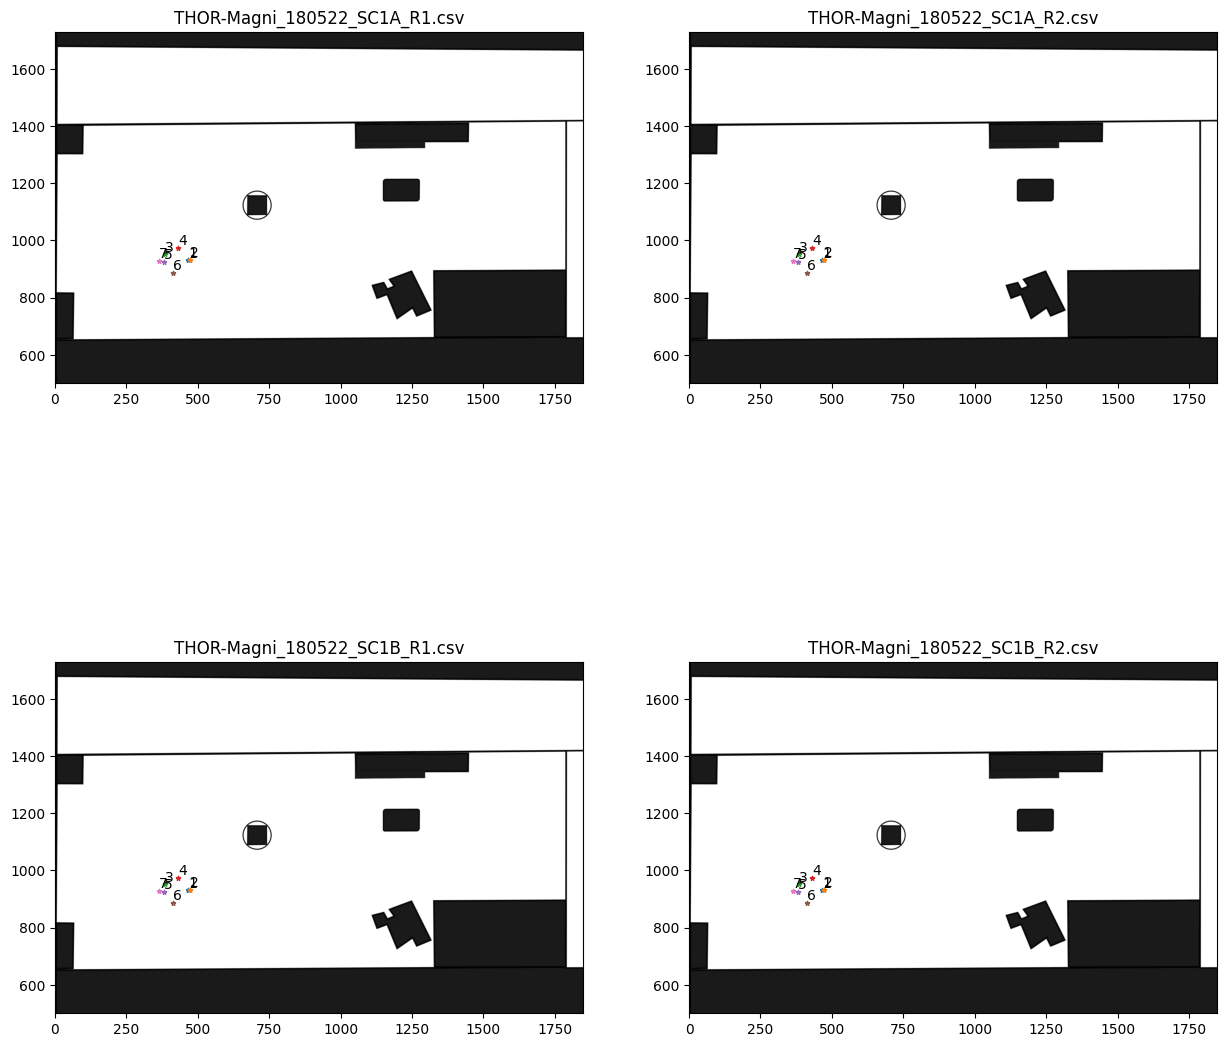

In [87]:
rows, cols = len(all_locations) // 2, len(all_locations) // 2
fig, axs = plt.subplots(rows, cols, figsize=(15, 15))
axs = axs.flatten()
for i in range(rows * cols):
    ax = axs[i]
    run = list(all_locations.keys())[i]
    locations = all_locations[run]
    ax.set_title(run)
    ax.imshow(map_layout)
    
    
    for marker_id, location_px in locations.items():
        ax.scatter(location_px[0], location_px[1], s = 10, marker="*")
        ax.text(location_px[0], location_px[1] + 10, marker_id)
    ax.set_xlim([0, 1850]);
    ax.set_ylim([500, 1730]);